# 🚀 Financial Report Analyzer (PDF Edition)

This notebook analyzes quarterly financial reports and generates a professional **PDF Report**, CSV, and Summary.

### Instructions
1. Put your PDF files (Q1, Q2, etc.) into a folder (e.g., `data/Bank_A`).
2. Run the cells below.
3. Enter your API Key and Folder Name when prompted.

In [1]:
# 1. Install Required Libraries
!pip install pdfplumber matplotlib pandas fpdf langchain-google-genai langchain-core

In [2]:
# 2. Imports
import pdfplumber
import json
import os
import getpass
import pandas as pd
import matplotlib.pyplot as plt
from fpdf import FPDF
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage

In [3]:
# 3. Logic Class (EarningsAnalyzer) - UPDATED FOR YOUR MODEL LIST
import time
import pdfplumber
import json
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
from fpdf import FPDF

class EarningsAnalyzer:
    def __init__(self, api_key):
        # ✅ FIX: Using a model explicitly listed in your diagnostic output
        self.llm = ChatGoogleGenerativeAI(
            model="gemini-2.5-flash", 
            google_api_key=api_key,
            temperature=0
        )

    def extract_text(self, file_path):
        """Reads the ENTIRE PDF (Pro Mode)."""
        text = ""
        try:
            with pdfplumber.open(file_path) as pdf:
                # Read up to 100 pages
                pages_to_read = min(len(pdf.pages), 100)
                print(f"      📖 Reading {pages_to_read} pages (Full Report)...")
                
                for i in range(pages_to_read):
                    extract = pdf.pages[i].extract_text()
                    if extract: text += extract
            return text
        except Exception as e:
            print(f"❌ Error reading {file_path}: {e}")
            return None

    def clean_json(self, raw_output):
        if raw_output is None: return None
        text = raw_output.replace("```json", "").replace("```", "").strip()
        try:
            return json.loads(text)
        except:
            return None

    def _call_with_retry(self, prompt, retries=3):
        for attempt in range(retries):
            try:
                return self.llm.invoke([HumanMessage(content=prompt)]).content
            except Exception as e:
                error_str = str(e)
                # Retry on server/network glitches
                if "500" in error_str or "Server disconnected" in error_str or "getaddrinfo" in error_str:
                    wait_time = 5 * (attempt + 1)
                    print(f"      ⚠️ Network/Server Glitch. Retrying in {wait_time}s...")
                    time.sleep(wait_time)
                # If 404, it means the model name is wrong again - crash immediately so we know
                elif "404" in error_str:
                    print(f"      ❌ Model Name Error: {e}")
                    raise e
                else:
                    raise e
        return None

    def analyze_full_report(self, text, q_name):
        # Limit payload to ~400k chars to stay safe
        if len(text) > 400000:
            text = text[:400000] 
        
        prompt = f"""
        You are a financial analyst. Extract data from this {q_name} report.
        
        CRITICAL RULES:
        1. Ignore "Year Ended" columns. ONLY use "Three Months Ended" (Quarterly).
        2. Return ONLY a valid JSON object. No intro text.
        3. If a data point is not mentioned, return 0 or an empty string.
        
        REQUIRED JSON STRUCTURE:
        {{
            "quarterly_revenue_bn": 0.0,
            "eps": 0.0,
            "net_interest_income_millions": 0,
            "dividend_per_share": 0.0,
            "assets_under_supervision_bn": 0.0,
            "total_headcount": 0,
            "write_offs_millions": 0.0,
            "credit_loss_provisions_millions": 0.0,
            "operating_expenses_bn": 0.0,
            "return_on_equity_bn": 0.0,
            "return_on_equity_tier1_captial_bn": 0.0,
            "net_profit_growth_percentage": 0.0,
            "liquidity_coverage_ratio_percentage": 0.0,
            "risk_weighted_assets_bn": 0.0,
            
            "key_highlights_summary": "Provide a 3-4 paragraph summary of highlights here",
            "critical_view_downplayed_items": "Provide the critical view of downplayed items here",
            "regulatory_legal_developments": "Summarise regulatory/legal developments here"
        }}
        
        REPORT TEXT:
        {text}
        """
        return self._call_with_retry(prompt)

    def generate_summary(self, data):
        context = json.dumps(data, indent=2)
        prompt = f"""
        Write a professional executive summary for these quarterly results.
        Focus on Revenue Trend, Headcount changes, and Write-offs/Risk.
        
        Data: {context}
        """
        return self._call_with_retry(prompt)

    def save_to_pdf(self, folder_path, report_name, summary_text, results):
        def sanitize_text(text):
            if not isinstance(text, str): return str(text)
            replacements = {
                '\u2018': "'", '\u2019': "'", '\u201c': '"', '\u201d': '"',
                '\u2013': '-', '\u2014': '-', '\u2026': '...', '\u00A3': 'GBP ', '\u20AC': 'EUR '
            }
            for char, rep in replacements.items(): text = text.replace(char, rep)
            return text.encode('latin-1', 'replace').decode('latin-1')

        pdf = FPDF()
        pdf.add_page()
        pdf.set_font("Arial", size=12)
        
        pdf.set_font("Arial", 'B', 16)
        pdf.cell(0, 10, txt=sanitize_text(f"Financial Analysis: {report_name}"), ln=True, align='C')
        pdf.ln(10)
        
        pdf.set_font("Arial", 'B', 14)
        pdf.cell(0, 10, txt="Executive Summary", ln=True, align='L')
        pdf.set_font("Arial", size=11)
        pdf.multi_cell(0, 7, txt=sanitize_text(summary_text))
        pdf.ln(10)
        
        pdf.set_font("Arial", 'B', 14)
        pdf.cell(0, 10, txt="Quarterly Metrics", ln=True, align='L')
        pdf.ln(5)
        
        pdf.set_font("Arial", 'B', 10)
        quarters = sorted(results.keys())
        metrics = [k for k in results[quarters[0]].keys() if isinstance(results[quarters[0]][k], (int, float))]
        
        pdf.cell(60, 10, "Metric", 1)
        for q in quarters: pdf.cell(30, 10, sanitize_text(q), 1)
        pdf.ln()
        
        pdf.set_font("Arial", size=10)
        for metric in metrics:
            clean_metric = sanitize_text(metric.replace("_", " ").title())
            pdf.cell(60, 10, clean_metric, 1)
            for q in quarters:
                val = str(results[q].get(metric, 0))
                pdf.cell(30, 10, val, 1)
            pdf.ln()

        pdf.add_page()
        pdf.set_font("Arial", 'B', 14)
        pdf.cell(0, 10, txt="Qualitative Insights", ln=True, align='L')
        pdf.ln(5)
        
        text_keys = [("Key Highlights", "key_highlights_summary"), ("Critical View", "critical_view_downplayed_items"), ("Regulatory", "regulatory_legal_developments")]
        
        for title, key in text_keys:
            pdf.set_font("Arial", 'B', 12)
            pdf.cell(0, 10, txt=sanitize_text(title), ln=True)
            pdf.set_font("Arial", size=10)
            combined_text = ""
            for q in quarters:
                q_text = results[q].get(key, "N/A")
                combined_text += f"[{q}]: {q_text}\n\n"
            pdf.multi_cell(0, 6, txt=sanitize_text(combined_text))
            pdf.ln(5)

        filename = os.path.join(folder_path, f"{report_name}_Report.pdf")
        pdf.output(filename)
        return filename

In [4]:
# 4. Configuration
GOOGLE_API_KEY = getpass.getpass("🔑 Enter your Google API Key: ")
folder_path = input("📂 Enter the folder path containing PDFs (e.g., my_financial_reports): ").strip()
report_name = input("📝 Enter a name for this analysis output (e.g., Bank_A_2025): ").strip()

🔑 Enter your Google API Key:  ········
📂 Enter the folder path containing PDFs (e.g., my_financial_reports):  UBS - 2025
📝 Enter a name for this analysis output (e.g., Bank_A_2025):  UBS - 2025 FY summary


In [5]:
# 5. Run Analysis Loop (Pro Version - No Delays)
import datetime

def log(message):
    print(f"[{datetime.datetime.now().strftime('%H:%M:%S')}] {message}")

if os.path.isdir(folder_path):
    files_to_process = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.pdf')]
    log(f"✅ Found {len(files_to_process)} PDF files")
else:
    files_to_process = []

analyzer = EarningsAnalyzer(GOOGLE_API_KEY)
results = {}

# Checkpoint logic (Still useful if your wifi drops!)
checkpoint_file = os.path.join(folder_path, f"{report_name}_checkpoint.csv")
if os.path.exists(checkpoint_file):
    try:
        results = pd.read_csv(checkpoint_file, index_col=0).to_dict(orient='index')
        log(f"🔄 Resumed with {len(results)} files done.")
    except: pass

log("🚀 Starting Pro Analysis...")

for filename in files_to_process:
    q_name = os.path.basename(filename).replace(".pdf", "")
    
    if q_name in results:
        log(f"⏩ Skipping {q_name}")
        continue

    log(f"📄 Analyzing {q_name}...")
    text = analyzer.extract_text(filename)
    
    if text:
        raw_json = analyzer.analyze_full_report(text, q_name)
        data = analyzer.clean_json(raw_json)
        
        if data:
            results[q_name] = data
            log(f"   ✅ Success!")
            pd.DataFrame(results).T.to_csv(checkpoint_file)

# Final Save
if results:
    log("📝 Generating Final Reports...")
    df = pd.DataFrame(results).T
    df.to_csv(os.path.join(folder_path, f"{report_name}.csv"))
    
    summary = analyzer.generate_summary(results)
    pdf_path = analyzer.save_to_pdf(folder_path, report_name, summary, results)
    log(f"✅ Done! Report saved: {pdf_path}")
    display(df)

[18:30:58] ✅ Found 3 PDF files
[18:30:59] 🚀 Starting Pro Analysis...
[18:30:59] 📄 Analyzing Q1...
      📖 Reading 92 pages (Full Report)...
      ⚠️ Network/Server Glitch. Retrying in 5s...
[18:33:11]    ✅ Success!
[18:33:11] 📄 Analyzing Q2...
      📖 Reading 99 pages (Full Report)...
[18:34:27]    ✅ Success!
[18:34:27] 📄 Analyzing Q3...
      📖 Reading 100 pages (Full Report)...
      ⚠️ Network/Server Glitch. Retrying in 5s...
[18:36:51]    ✅ Success!
[18:36:51] 📝 Generating Final Reports...
[18:37:07] ✅ Done! Report saved: UBS - 2025\UBS - 2025 FY summary_Report.pdf


,quarterly_revenue_bn,eps,net_interest_income_millions,dividend_per_share,assets_under_supervision_bn,total_headcount,write_offs_millions,credit_loss_provisions_millions,operating_expenses_bn,return_on_equity_bn,return_on_equity_tier1_captial_bn,net_profit_growth_percentage,liquidity_coverage_ratio_percentage,risk_weighted_assets_bn,key_highlights_summary,critical_view_downplayed_items,regulatory_legal_developments
Q1,12.557,0.51,1629,0.9,6153.0,106789,121.0,100,10.324,7.9,9.6,-3.6,181.0,483.276,UBS Group reported a net profit attributable t...,Despite positive integration progress and cost...,"In Switzerland, amendments to the Capital Adeq..."
Q2,12.112,0.72,1965,0.9,6618.0,105132,163.0,2966,9.756,0.0,0.0,110.9,182.3,504.5,UBS Group reported a strong second quarter of ...,"Despite strong reported profits, UBS faces sig...","In June 2025, the Swiss Federal Council publis..."
Q3,12.76,0.76,1981,0.0,6910.0,104427,0.0,102,9.831,0.0,0.0,74.2,182.1,504.897,UBS Group reported a strong third quarter in 2...,"Despite overall revenue growth, a critical loo...",Significant regulatory developments in Switzer...


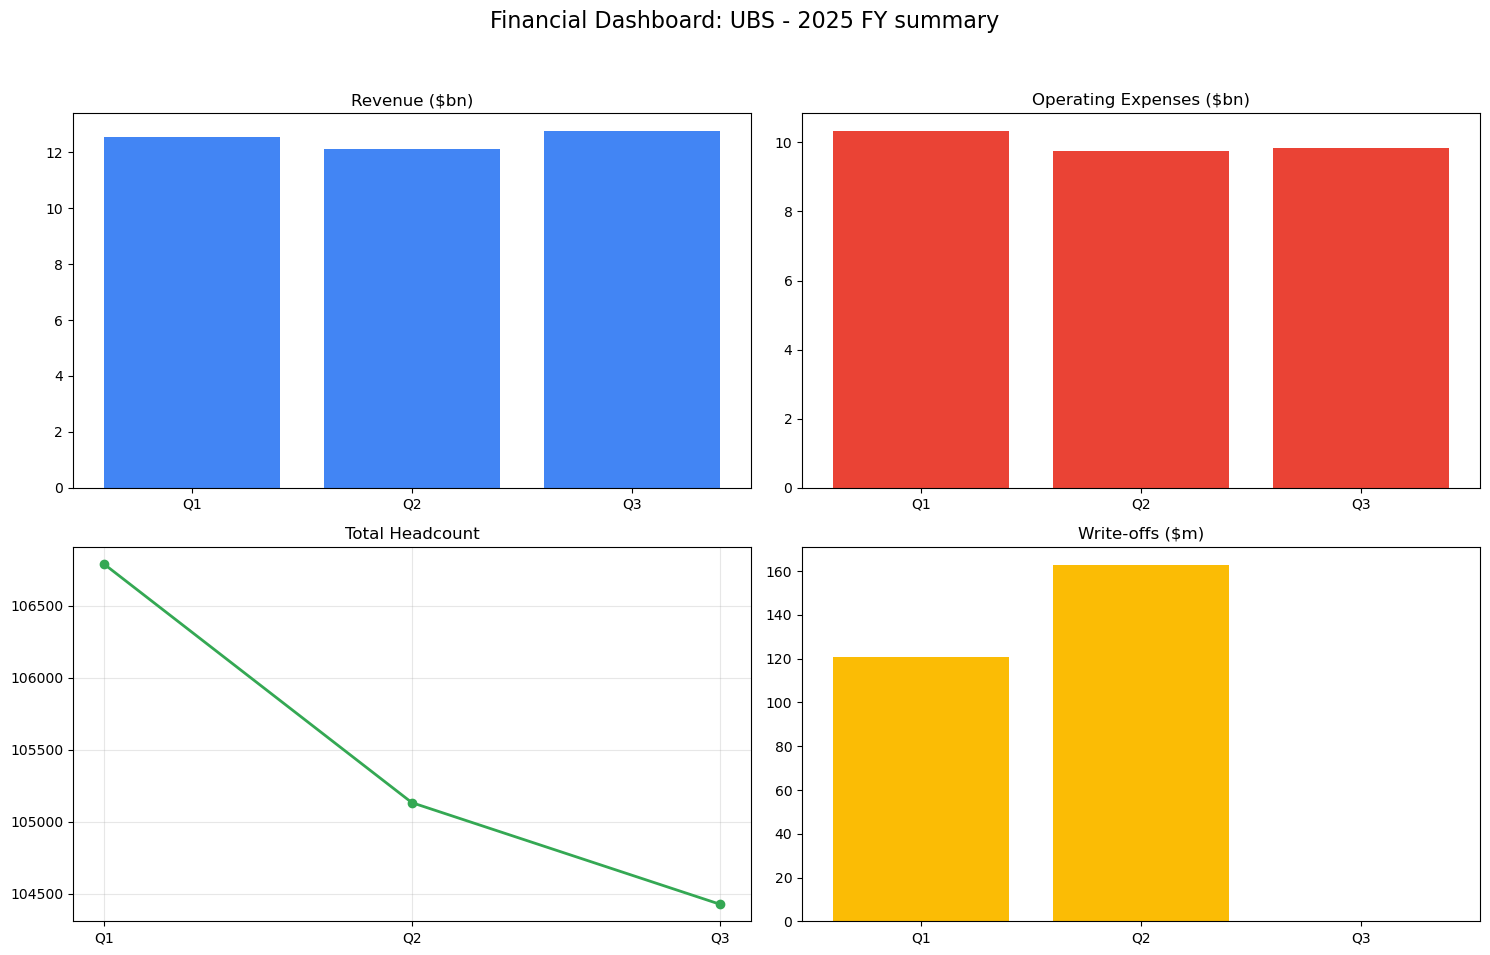

In [6]:
# 6. Visualizations
if results:
    quarters = sorted(results.keys())
    revs = [results[q].get('quarterly_revenue_bn', 0) for q in quarters]
    headcount = [results[q].get('total_headcount', 0) for q in quarters]
    write_offs = [results[q].get('write_offs_millions', 0) for q in quarters]
    expenses = [results[q].get('operating_expenses_bn', 0) for q in quarters]

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Financial Dashboard: {report_name}', fontsize=16)

    axs[0, 0].bar(quarters, revs, color='#4285F4')
    axs[0, 0].set_title('Revenue ($bn)')
    
    axs[0, 1].bar(quarters, expenses, color='#EA4335')
    axs[0, 1].set_title('Operating Expenses ($bn)')

    axs[1, 0].plot(quarters, headcount, marker='o', color='#34A853', linewidth=2)
    axs[1, 0].set_title('Total Headcount')
    axs[1, 0].grid(True, alpha=0.3)

    axs[1, 1].bar(quarters, write_offs, color='#FBBC05')
    axs[1, 1].set_title('Write-offs ($m)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()